# Training Data

The training data is generated using real HSC images from the Ultra Deep (UD) field. The ground truth source detection masks are generated using the [scarlet](https://github.com/pmelchior/scarlet) deblender. HSC UD data can be accessed from https://hsc-release.mtk.nao.ac.jp/doc/index.php/tools-2/. We used the public DR2 UD stacks from: https://hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results. The HSC DR2 data is described in [Hiroaki et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PASJ...71..114A/abstract).

In [1]:
# In case you need to point to pre-existing scarlet install
import sys
sys.path.insert(1, '/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/')

In [2]:
import sys, os
import numpy as np
import time
import scarlet
import sep
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

In [3]:
# Print the versions to test the imports and so we know what works
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+gfde109a
1.20.1
1.1.1


### Test Scarlet

First, let's test scarlet using one HSC UD image. The HSC image data is divided into "tracts" and "patches" on the sky. You can get the HSC image data given any ra, dec using the code below.

View HSC tract maps: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data/


Tract, patch from coord: 9814 (6, 6) 

Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9814/6,6/calexp-HSC-G-9814-6,6.fits".


/home/paleo2/ASTRODET/workspace/astrodet/astrodet/hsc.py:85: UserWarning: Overriding tract/patch info and looking for HSC file at requested coordinates.
  warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")


Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9814/6,6/calexp-HSC-R-9814-6,6.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9814/6,6/calexp-HSC-I-9814-6,6.fits".

sigma_obs: 2.0 pixels.
Source catalog found  735 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 13 iterations to logL = -2923566.145554284


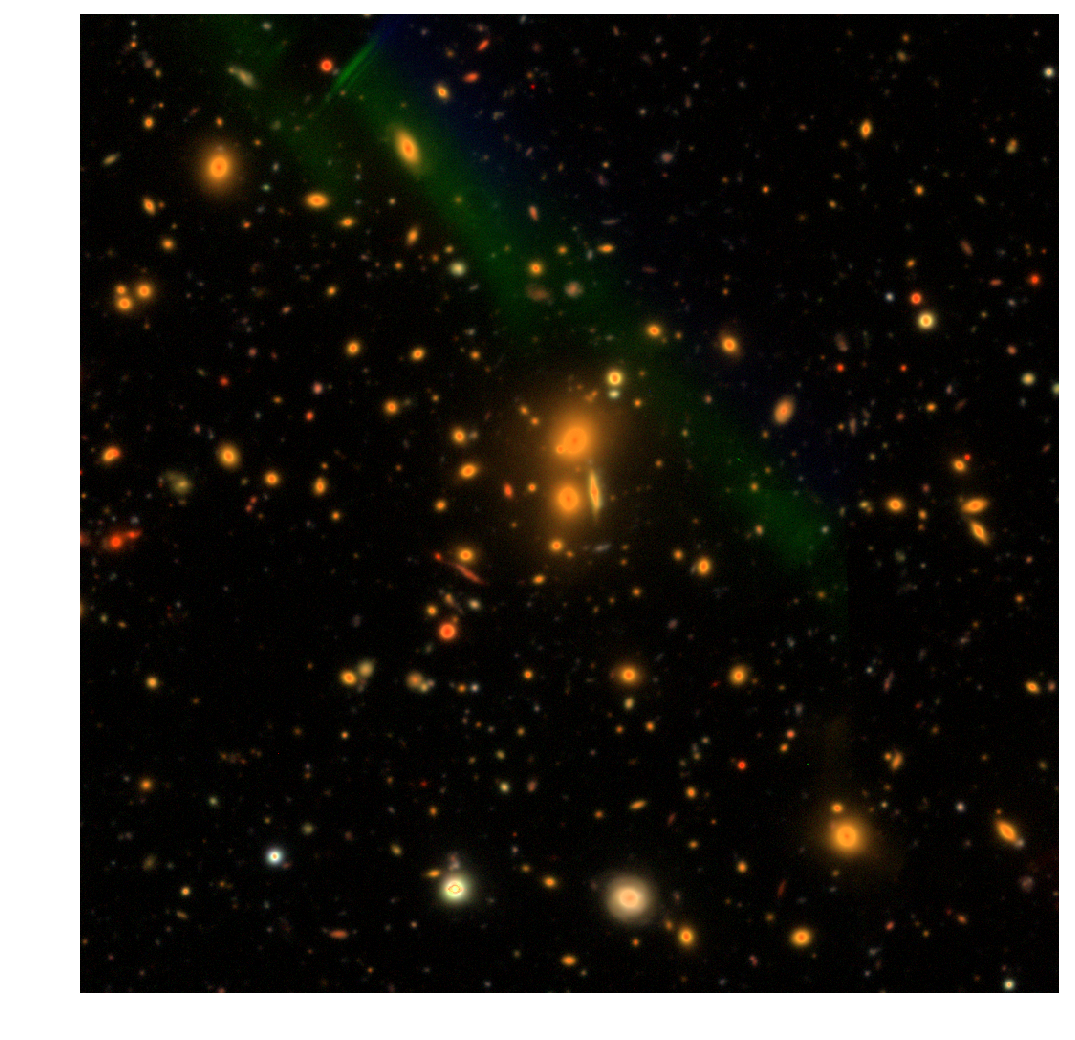

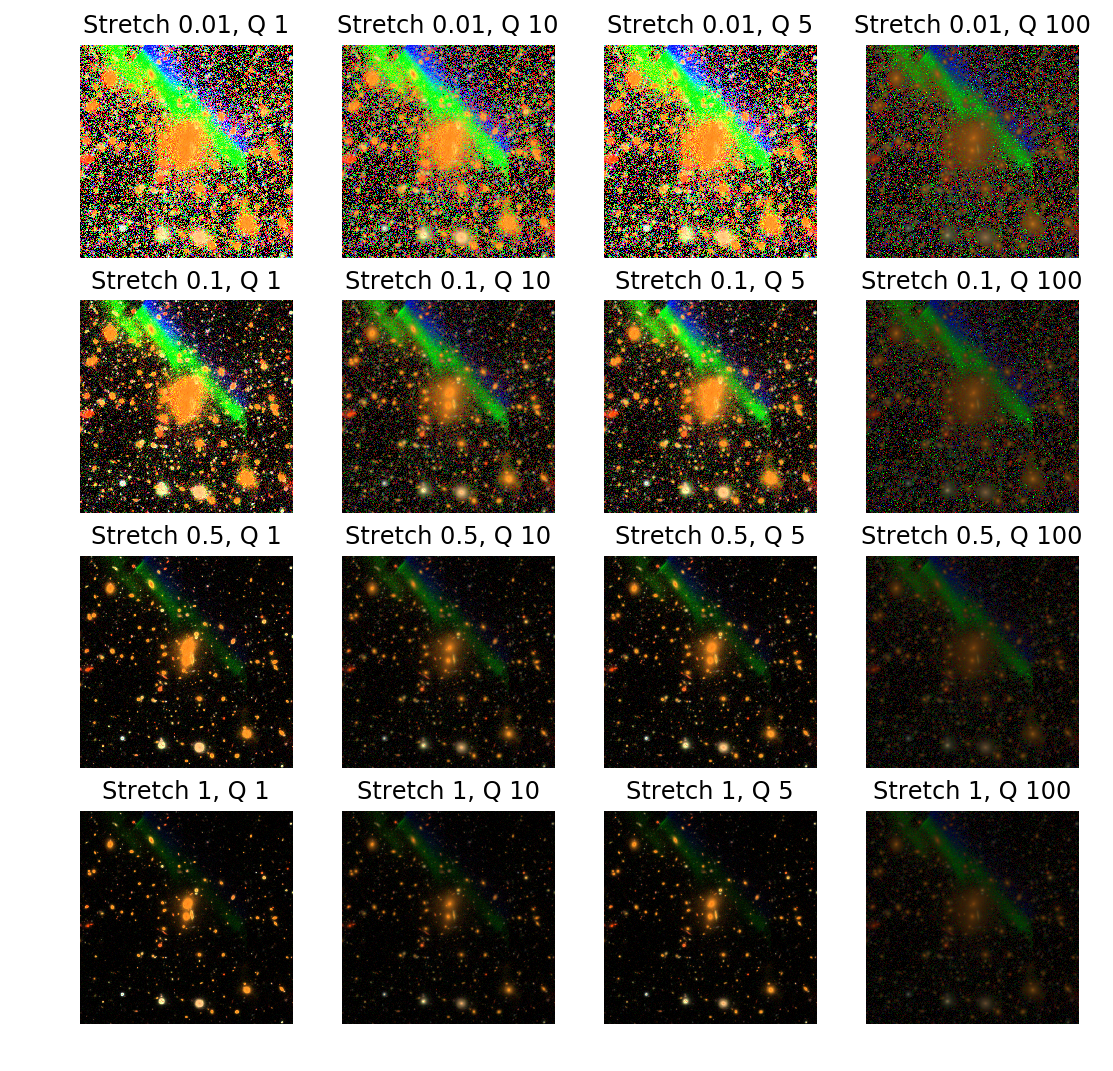

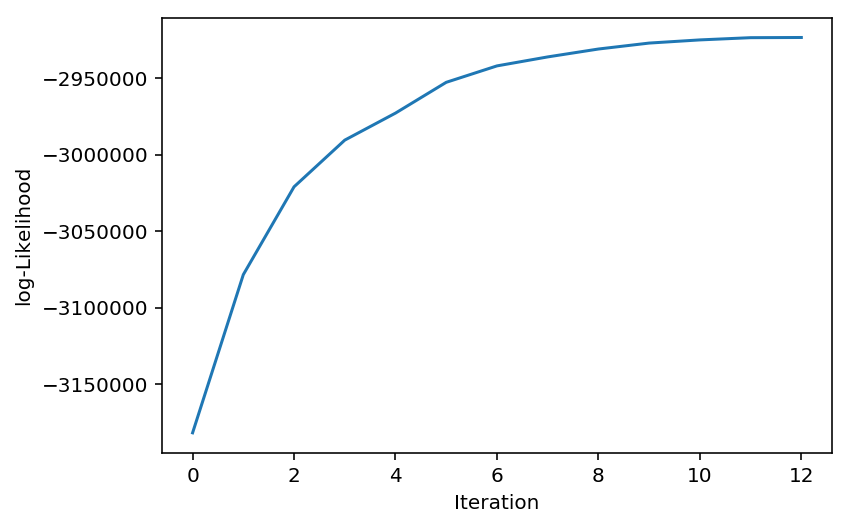

Computing residuals.


Zero or negative spectrum [-0.4717841  -0.54063857 -0.58138144] at (369.73069399561166, 124.4149174401741)
No flux in morphology model for source at (391.59013486538635, 134.91517052555756)
Zero or negative spectrum [-0.13616964 -0.50192106 -0.00475182] at (385.7118062341952, 411.6544304611418)
No flux in morphology model for source at (884.4965637366716, 702.524054846426)
Zero or negative spectrum [-0.08971895 -1.1132892  -1.0789362 ] at (204.3035807283489, 863.4754556755074)


Re-fitting with Starlet models for poorly-fit sources.
Fitting Blend model.
Scarlet ran for 24 iterations to logL = -4412138.8629904315


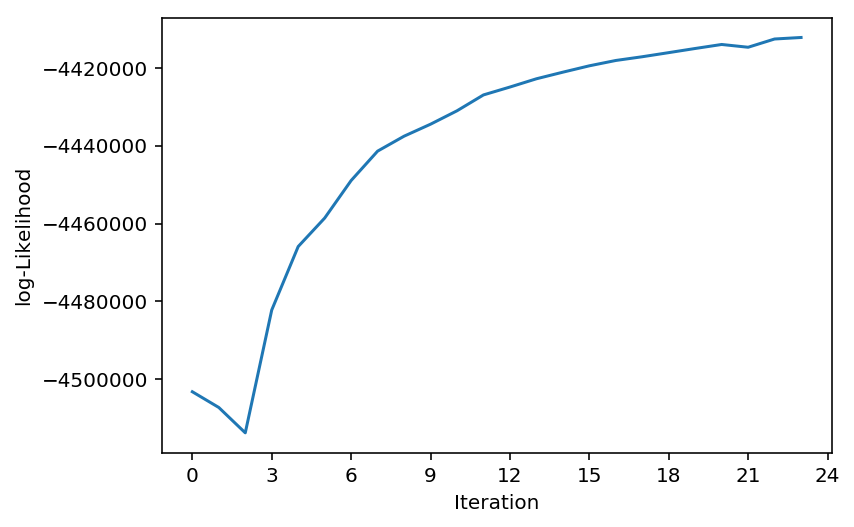

Extracting deblended catalog.


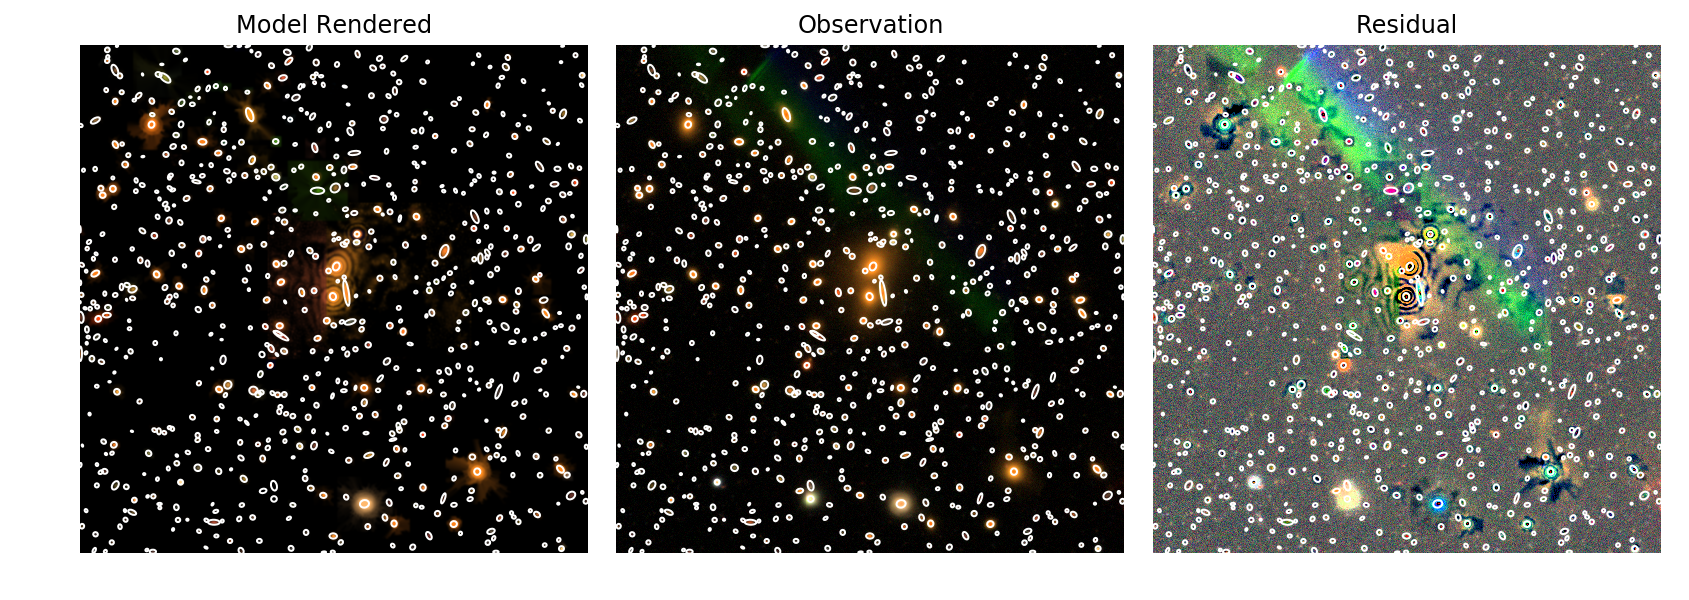


Writing scarlet results...

Saved scarlet results successfully! 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

CPU times: user 24min 50s, sys: 33.7 s, total: 25min 24s
Wall time: 25min 18s


In [4]:
%%time

from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

from astrodet.hsc import get_tract_patch_from_coord, get_hsc_data
from astrodet.scarlet import plot_stretch_Q, run_scarlet, write_scarlet_results

filters = ['g', 'r', 'i']

# Input coordinate
c = SkyCoord(151.3816, 2.5854, unit='deg')

def run_scarlet_hsc_example(c, _plot_image, _plot_stretch_Q, _plot_scene, cutout_size=[1024, 1024]):
    """
    Parameters
    ----------
    c : SkyCoord object
          The ra, dec pointing (single or lists of pointings)
    _plot_image : bool
          Helper function to plot the image scarlet is to run on
    _plot_stretch_Q : bool
          Helper function to plot different normalizations of your image using the stretch, Q parameters.
    _plot_scene : bool
          Helper function to plot scene with scarlet
    cutout_size : [int, int]
          Cutout shape of image
          
    Returns
    -------
    The scarlet image test in FITS files.
    
    """
    
    # Get the tract, patch
    tract, patch = get_tract_patch_from_coord(c)
    print('\nTract, patch from coord:', tract, patch, "\n")

    # Point to the HSC data directory
    hsc_dirpath = '/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/'

    # Get the HSC data from the file info
    # If you want a cutout centered a coordinate, you can must pass the coord argument directly into get_hsc_data
    # Otherwise, you can provide patch and tract and the cutout will be centered on the patch image center

    # Time vs image size is O(N^3), so 1024x1024 for training set sizes
    #cutout_size = cutout_size
    datas = get_hsc_data(dirpath=hsc_dirpath, filters=filters, coord=c, cutout_size=cutout_size)

    # Plot image data
    if _plot_image == True:
        fig, ax = plt.subplots(1, 1, figsize=(9,9))
        norm = scarlet.display.AsinhMapping(minimum=0, stretch=1, Q=5)
        img_rgb = scarlet.display.img_to_rgb(datas, norm=norm)
        ax.imshow(img_rgb)
        ax.axis('off')

    # Find good stretch and Q
    if _plot_stretch_Q == True: fig = plot_stretch_Q(datas);

    ### Run scarlet on image ###

    # HSC pixel scale in arcsec/pixel
    ps = 0.17
    # Approximate PSF size in UD field according to HSC DR2 paper is 0.8 arcsec
    sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
    print(f'\nsigma_obs: {np.around(sigma_obs, 2)} pixels.')

    # Run Scarlet
    # START TIMING with plotting OFF
    out = run_scarlet(datas, filters, sigma_model=1, sigma_obs=sigma_obs, plot_scene=_plot_scene,
                      max_chi2=5000, morph_thresh=0.01, starlet_thresh=0.01, stretch=1, Q=5)
    # END TIMING

    # Unpack output
    observation, starlet_sources, model_frame, catalog, catalog_deblended, segmentation_masks = out

    print("\nWriting scarlet results...")

    # Save Scarlet data to FITS file
    filenames = write_scarlet_results(datas, observation, starlet_sources, model_frame, 
                                     catalog_deblended, segmentation_masks, dirpath='.', 
                                     filters=filters, tract=tract, patch=patch)
    
    print("\nSaved scarlet results successfully! \n")
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n")
    
run_scarlet_hsc_example(c=c, _plot_image=True, _plot_stretch_Q=True, _plot_scene=True)

### Run SkyCoords test

In [5]:
ras = [149.9234, 149.8460, 149.9244, 150.4154, 151.2481, 150.1958, 148.4212, 150.7502]
decs = [3.0282, 2.8791, 3.0290, 2.4298, 1.8747, 1.6495, 1.5768, 2.3446]

# Initialize a single skycoord obj with all coordinates 
c = SkyCoord(ras, decs, unit='deg')

run_scarlet_hsc_example(c=c, _plot_image=False, _plot_stretch_Q=False, _plot_scene=False, cutout_size=[150, 150])

TypeError: only integer scalar arrays can be converted to a scalar index


Tract, patch from coord: 9813 (6, 8) 

Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9813/6,8/calexp-HSC-G-9813-6,8.fits".


/home/paleo2/ASTRODET/workspace/astrodet/astrodet/hsc.py:85: UserWarning: Overriding tract/patch info and looking for HSC file at requested coordinates.
  warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")


Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9813/6,8/calexp-HSC-R-9813-6,8.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9813/6,8/calexp-HSC-I-9813-6,8.fits".

sigma_obs: 2.0 pixels.
Source catalog found  5 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 4 iterations to logL = -31008.255351543296


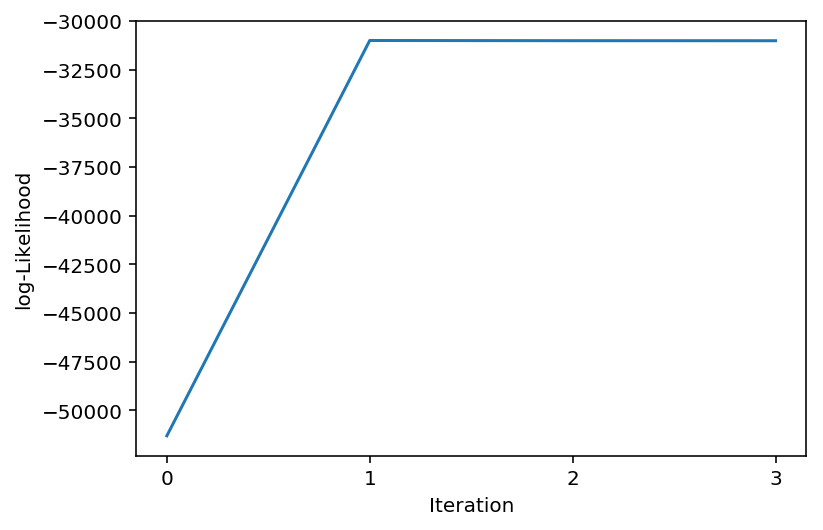

Computing residuals.
Re-fitting with Starlet models for poorly-fit sources.
Fitting Blend model.
Scarlet ran for 23 iterations to logL = -27726.7798535192


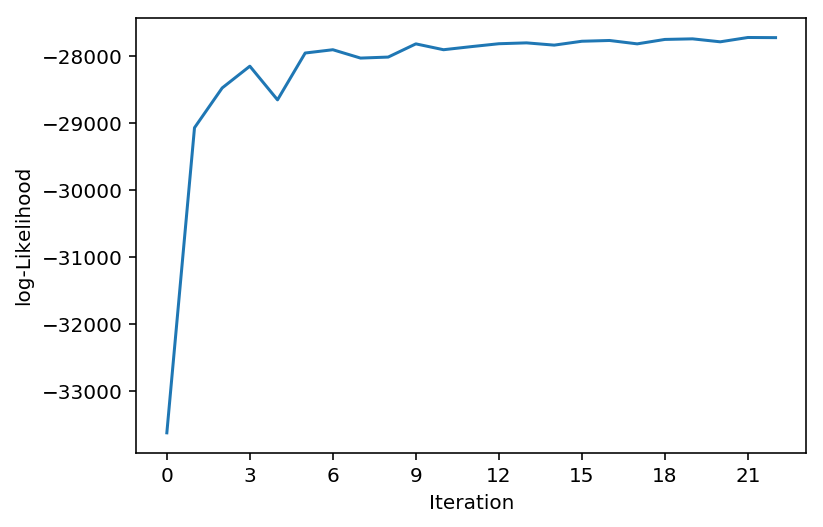

Extracting deblended catalog.

Writing scarlet results...

Saved scarlet results successfully! 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Tract, patch from coord: 9813 (6, 7) 

Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9813/6,7/calexp-HSC-G-9813-6,7.fits".


/home/paleo2/ASTRODET/workspace/astrodet/astrodet/hsc.py:85: UserWarning: Overriding tract/patch info and looking for HSC file at requested coordinates.
  warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")


Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9813/6,7/calexp-HSC-R-9813-6,7.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9813/6,7/calexp-HSC-I-9813-6,7.fits".

sigma_obs: 2.0 pixels.
Source catalog found  11 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 5 iterations to logL = -27585.49531983845


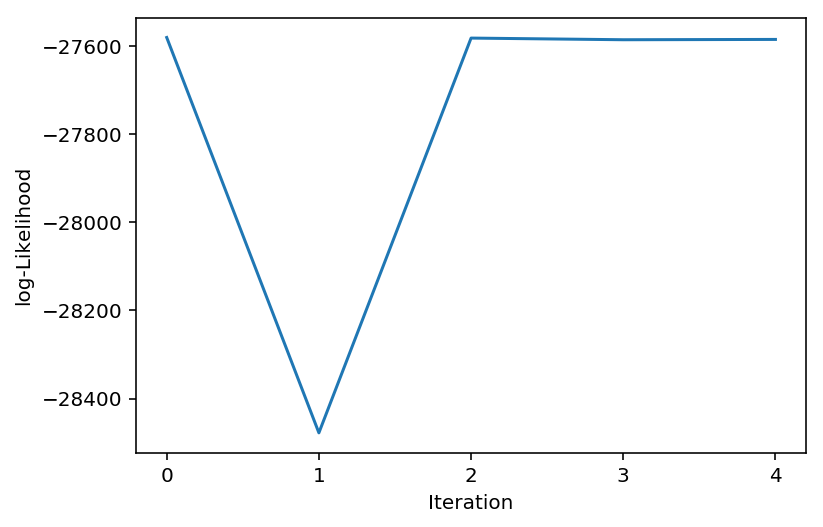

Computing residuals.
Extracting deblended catalog.

Writing scarlet results...

Saved scarlet results successfully! 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Tract, patch from coord: 9813 (6, 8) 

Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9813/6,8/calexp-HSC-G-9813-6,8.fits".


/home/paleo2/ASTRODET/workspace/astrodet/astrodet/hsc.py:85: UserWarning: Overriding tract/patch info and looking for HSC file at requested coordinates.
  warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")


Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9813/6,8/calexp-HSC-R-9813-6,8.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9813/6,8/calexp-HSC-I-9813-6,8.fits".

sigma_obs: 2.0 pixels.
Source catalog found  8 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 5 iterations to logL = -29810.47141631509


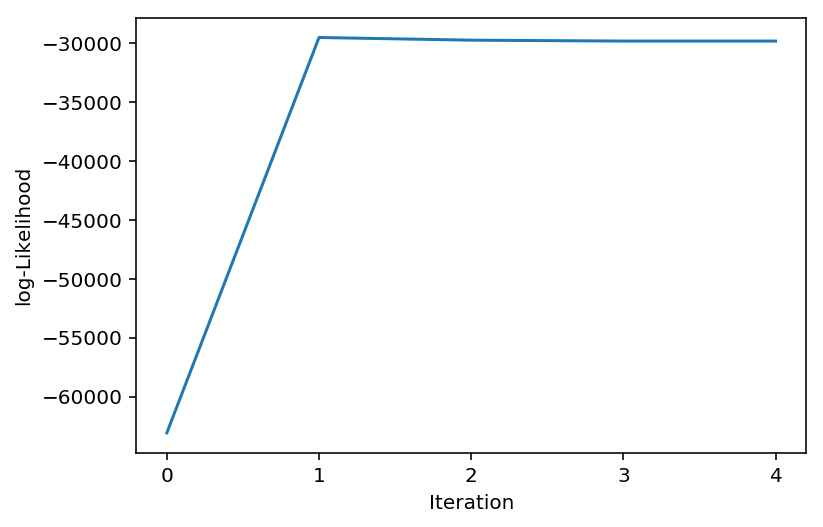

Computing residuals.
Extracting deblended catalog.

Writing scarlet results...

Saved scarlet results successfully! 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Tract, patch from coord: 9813 (3, 5) 

Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9813/3,5/calexp-HSC-G-9813-3,5.fits".


/home/paleo2/ASTRODET/workspace/astrodet/astrodet/hsc.py:85: UserWarning: Overriding tract/patch info and looking for HSC file at requested coordinates.
  warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")


Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9813/3,5/calexp-HSC-R-9813-3,5.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9813/3,5/calexp-HSC-I-9813-3,5.fits".

sigma_obs: 2.0 pixels.
Source catalog found  5 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 118 iterations to logL = -28009.029544401903


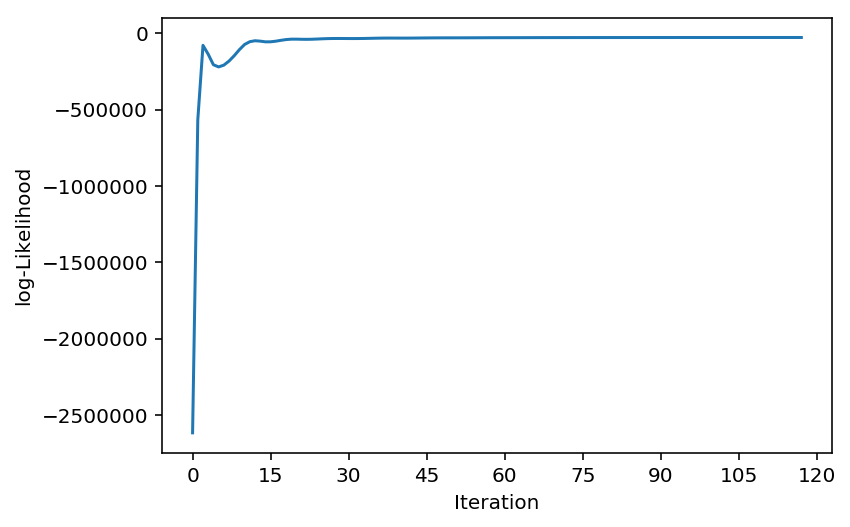

Computing residuals.
Re-fitting with Starlet models for poorly-fit sources.
Fitting Blend model.
Scarlet ran for 76 iterations to logL = -28195.383997510253


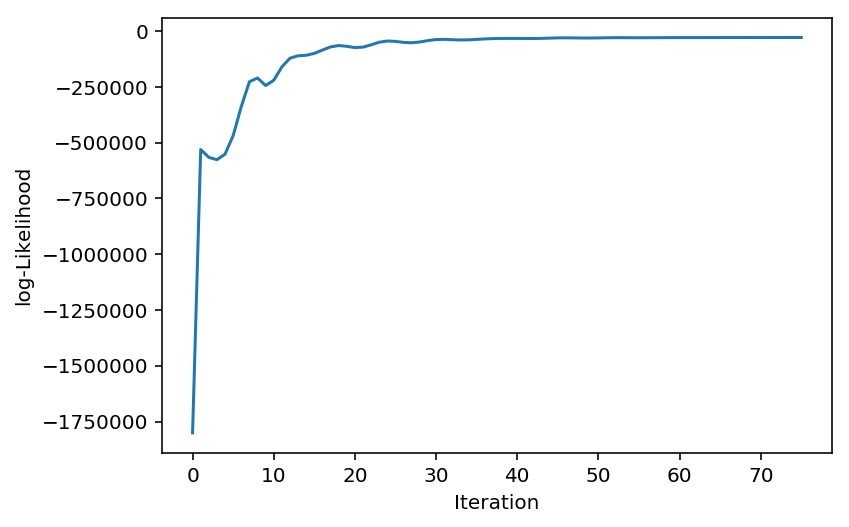

Extracting deblended catalog.

Writing scarlet results...

Saved scarlet results successfully! 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Tract, patch from coord: 9814 (7, 2) 

Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9814/7,2/calexp-HSC-G-9814-7,2.fits".


/home/paleo2/ASTRODET/workspace/astrodet/astrodet/hsc.py:85: UserWarning: Overriding tract/patch info and looking for HSC file at requested coordinates.
  warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")


Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9814/7,2/calexp-HSC-R-9814-7,2.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9814/7,2/calexp-HSC-I-9814-7,2.fits".

sigma_obs: 2.0 pixels.
Source catalog found  12 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 54 iterations to logL = -28525.90841151464


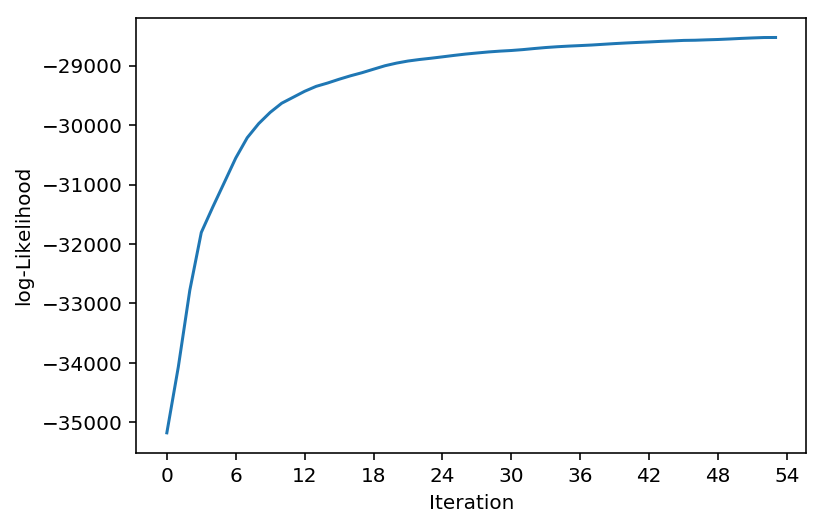

Computing residuals.
Re-fitting with Starlet models for poorly-fit sources.
Fitting Blend model.
Scarlet ran for 40 iterations to logL = -30583.417898123156


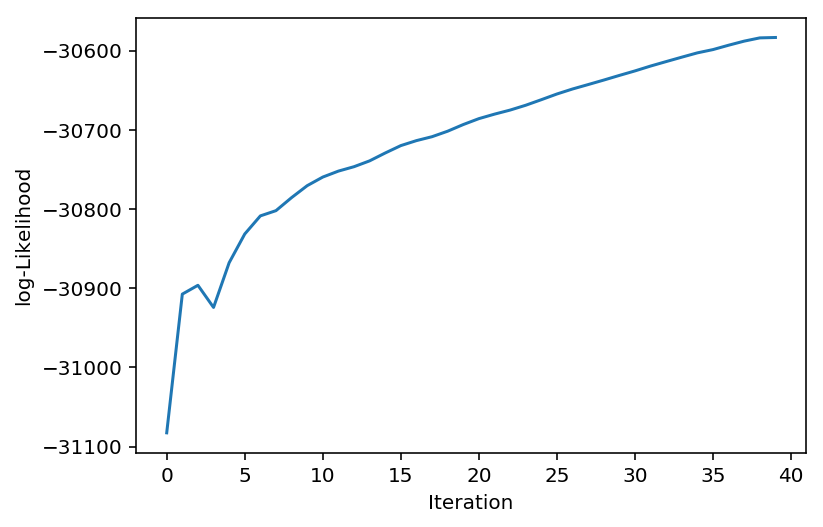

Extracting deblended catalog.

Writing scarlet results...

Saved scarlet results successfully! 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Tract, patch from coord: 9813 (4, 1) 

Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9813/4,1/calexp-HSC-G-9813-4,1.fits".


/home/paleo2/ASTRODET/workspace/astrodet/astrodet/hsc.py:85: UserWarning: Overriding tract/patch info and looking for HSC file at requested coordinates.
  warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")


Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9813/4,1/calexp-HSC-R-9813-4,1.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9813/4,1/calexp-HSC-I-9813-4,1.fits".

sigma_obs: 2.0 pixels.
Source catalog found  6 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 3 iterations to logL = -27599.72802144371


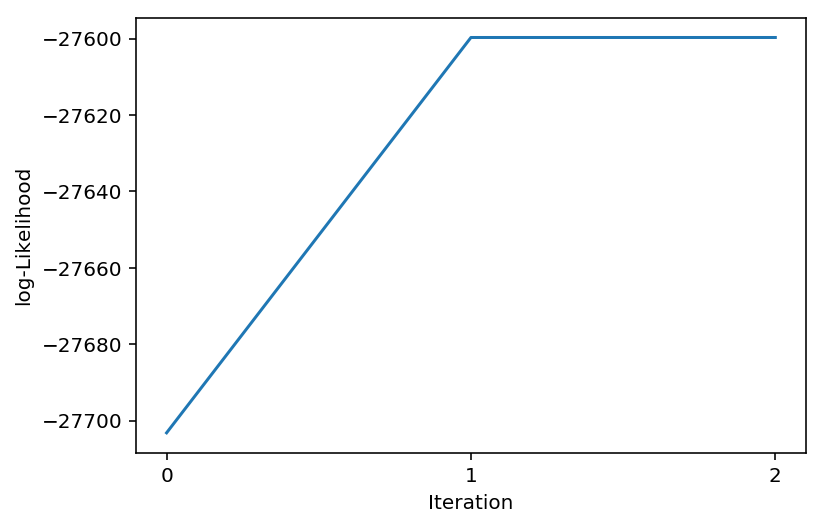

Computing residuals.
Extracting deblended catalog.

Writing scarlet results...

Saved scarlet results successfully! 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Tract, patch from coord: 9812 (6, 0) 

Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9812/6,0/calexp-HSC-G-9812-6,0.fits".


/home/paleo2/ASTRODET/workspace/astrodet/astrodet/hsc.py:85: UserWarning: Overriding tract/patch info and looking for HSC file at requested coordinates.
  warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")


Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9812/6,0/calexp-HSC-R-9812-6,0.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9812/6,0/calexp-HSC-I-9812-6,0.fits".

sigma_obs: 2.0 pixels.
Source catalog found  8 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 200 iterations to logL = -68901.4368062804


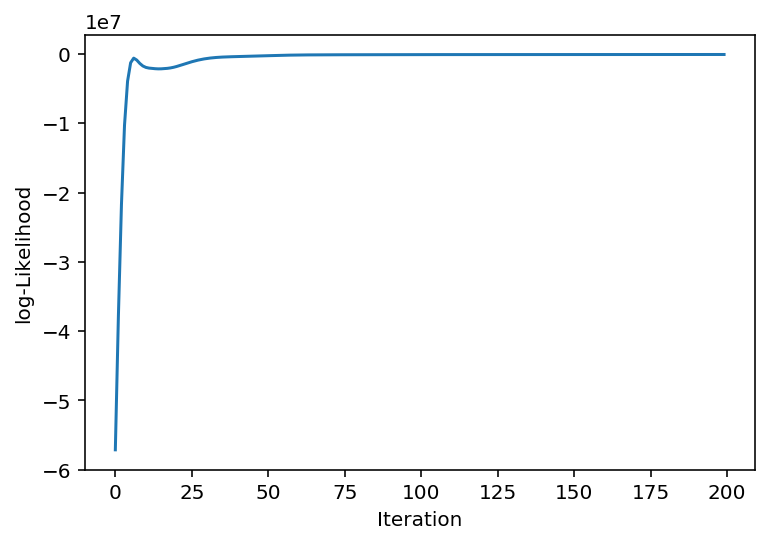

Computing residuals.
Re-fitting with Starlet models for poorly-fit sources.
Fitting Blend model.
Scarlet ran for 15 iterations to logL = -2163569.181271956


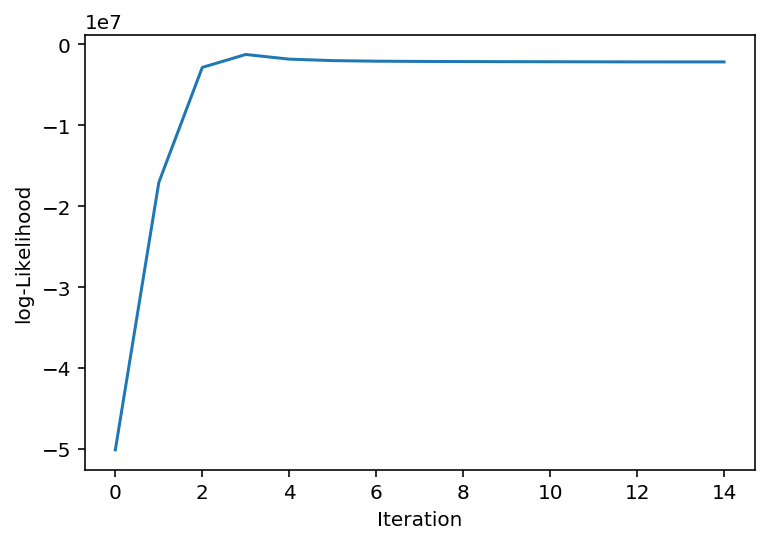

Extracting deblended catalog.

Writing scarlet results...

Saved scarlet results successfully! 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Tract, patch from coord: 9813 (1, 5) 

Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9813/1,5/calexp-HSC-G-9813-1,5.fits".


/home/paleo2/ASTRODET/workspace/astrodet/astrodet/hsc.py:85: UserWarning: Overriding tract/patch info and looking for HSC file at requested coordinates.
  warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")


Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9813/1,5/calexp-HSC-R-9813-1,5.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9813/1,5/calexp-HSC-I-9813-1,5.fits".

sigma_obs: 2.0 pixels.
Source catalog found  6 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 43 iterations to logL = -29695.966641058836


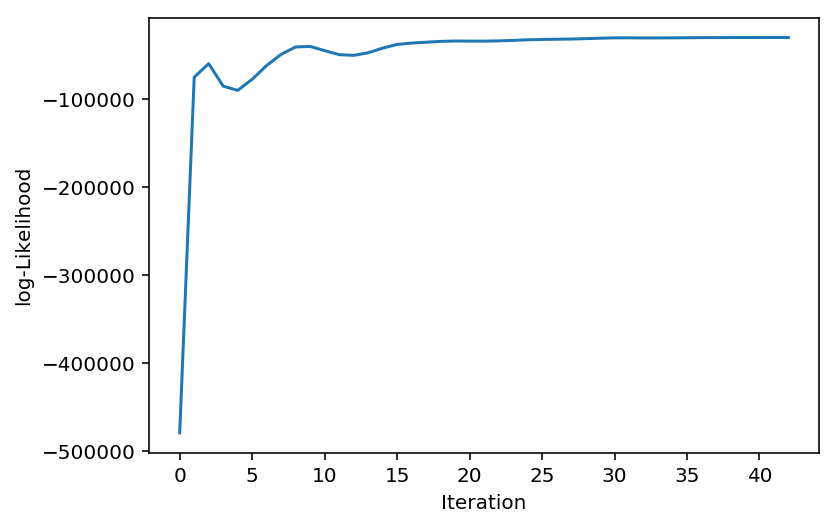

Computing residuals.
Re-fitting with Starlet models for poorly-fit sources.
Fitting Blend model.
Scarlet ran for 47 iterations to logL = -28003.314178441942


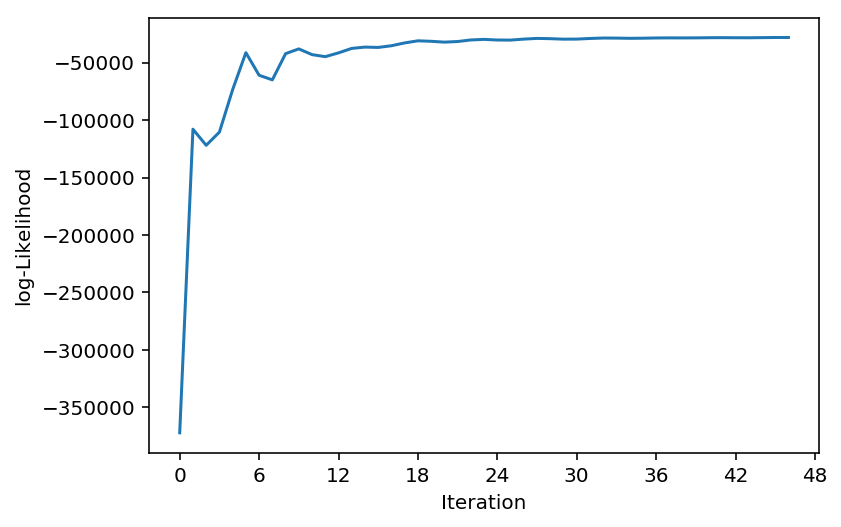

Extracting deblended catalog.

Writing scarlet results...

Saved scarlet results successfully! 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

CPU times: user 2min 26s, sys: 242 ms, total: 2min 27s
Wall time: 2min 24s


In [6]:
%%time

filters = ['g', 'r', 'i']

ras = [149.9234, 149.8460, 149.9244, 150.4154, 151.2481, 150.1958, 148.4212, 150.7502]
decs = [3.0282, 2.8791, 3.0290, 2.4298, 1.8747, 1.6495, 1.5768, 2.3446]

#small cutout size b/c I don't want to wait forever

for ra, dec in zip(ras, decs):
    c = SkyCoord(ra, dec, unit='deg')
    run_scarlet_hsc_example(c=c, _plot_image=False, _plot_stretch_Q=False, _plot_scene=False, cutout_size=[100, 100])

### Generate training data

In [ ]:
def generate_training_data(dirpath, filters=['g','r','i'], ratios=[1, 0.2, 0.2]):
    
    """
    Description.
    
    
    
    """
    
    import glob
    
    dirpath_write = os.path.join(dirpath, 'training_data')
    
    # HSC pixel scale in arcsec/pixel
    ps = 0.17
    # Approximate PSF size in UD field according to HSC DR2 paper is 0.8 arcsec
    sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
        
    # Normalize ratios to sum to 1
    ratios = ratios / np.sum(ratios)
    
    # Get all HSC data
    files = []
    f = filters[0]
    f = f.upper()
    
    files = glob.glob(os.path.join(dirpath, f'HSC-{f}/**/**/calexp-HSC-{f}-*.fits.gz'), recursive=True)
    # Randomize file order
    np.random.shuffle(files)
            
    # Split dataset into training, validation, and test using ratios
    ln = len(files)
    i_train = int(np.floor(ln*ratios[0]))
    i_val = int(np.floor(ln*ratios[1]))
    i_test = int(np.floor(ln*ratios[1]))
    
    # Split using index
    files_val = files[:i_val]
    files_test = files[i_val:i_val + i_test]
    files_train = files[i_val + i_test:]
    
    # Run scarlet on training and test datasets
    for i, f in enumerate([files_train, files_test]):
        
        # Get tract, patch (use first band)
        for fi in f:
            
            # TODO: Do some multiprocessing
            # partition one 1024x1024 image to each CPU

            s = fi.split(f'calexp-HSC-{f}-')[1].split('.fits.gz')[0]
            tract, patch = s.split('-')
            patch = tuple(map(int, patch.split(',')))
            
            # Run Scarlet
            out = run_scarlet(datas, filters, sigma_model=1, sigma_obs=sigma_obs, plot_scene=True,
                              max_chi2=5000, morph_thresh=0.01, starlet_thresh=0.01, stretch=1, Q=5)
            
            # Unpack output
            observation, starlet_sources, model_frame, catalog, catalog_deblended, segmentation_masks = out

            # Save Scarlet data to FITS file
            filenames = write_scarlet_results(datas, observation, starlet_sources, model_frame, 
                                             catalog_deblended, segmentation_masks, dirpath=dirpath_write, 
                                             filters=filters, tract=tract, patch=patch)
        
    return files_train, files_val, files_test